<a href="https://colab.research.google.com/github/PepperJao/Modeling/blob/master/Task3_of_%E2%80%9CCNN_Lab_01_MNIST_MLP_vs_CNN_Bakeoff_ipynb%E2%80%9D_by_Pepper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In this notebook we're going to explore handwritten digit recognition task using MNIST database and CNNs

In [0]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Set style

In [0]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [0]:
np.random.seed(41)

# Data

In this tutorial we're going to use MNIST dataset with handwritten digits.

## MNIST overview

Let's download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [36]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(len(X_train), 'train samples')
print(len(X_test), 'test samples')

60000 train samples
10000 test samples


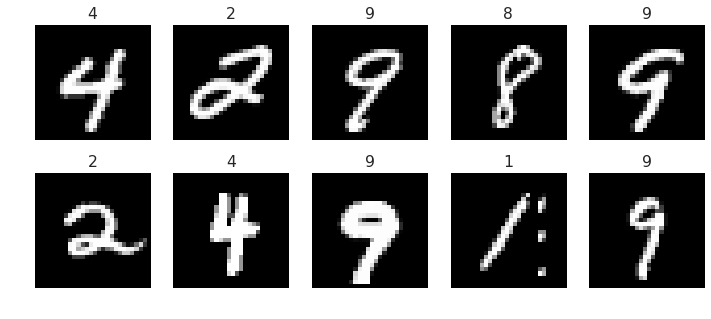

In [37]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let's see objects are distributed among classes

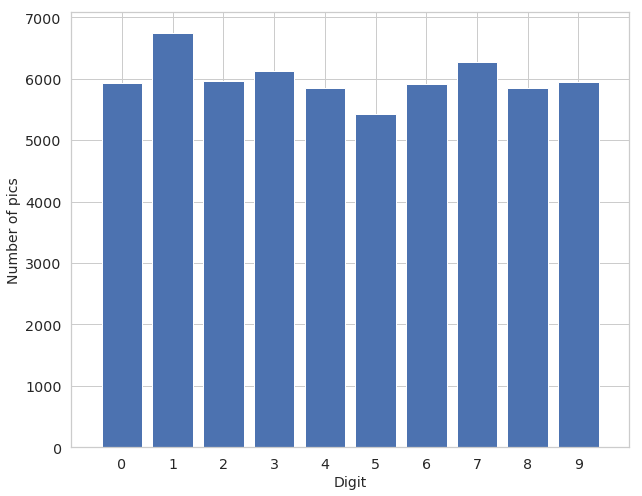

In [38]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(0, 10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14)
plt.show()

As one can see, the task is pretty balanced

## Data preparation

First of all, let's predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [0]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

The thing that is different in Theano and Tensorflow is order of these dimensions inside tensor.

With Theano yo're going to have 4-dimensional tensor with the following dimensions: **(Objects, Channels, Image rows,Image columns)**. Assume that $\text{X_train}$ is our tensor. Then $\text{X_train}[0]$ gives you one trainig object - it is an image with few channels in general case. $\text{X_train}[0][0]$ gives you the first channel of the first object. And so on. The logic of tensors should be clear now.

In Tensorflow the order is the following: **(Objects, Image rows,Image columns, Channels)**

Thus we need to check what dimension order do we have and reshape our tensor in accordance with it:

In [0]:
img_rows, img_cols = 28, 28
nb_classes = 10
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Here we have grayscale image and thus the number of the channels is $1$. Here I used Tensorflow library with the corresponding order of dimensions

In [41]:
print('X_train shape:', X_train.shape)

X_train shape: (60000, 28, 28, 1)


Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let's have our data in $[0; 1]$ interval $-$ it's common choice for grayscale images.

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Last step is to convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer in CNN

In [0]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

# Dense baseline model

First of all, let's build MLP model and see how it performs

In [0]:
model_dense = Sequential()

In [0]:
'''

model_dense.add(Dense(128, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(nb_classes, activation="softmax"))
'''
model_dense.add(Dense(256, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(nb_classes, activation="softmax"))


Our model the the following architercture

In [46]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


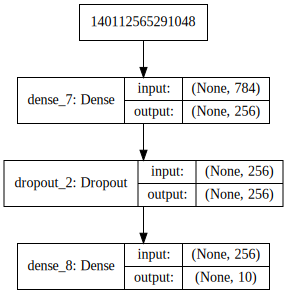

In [47]:
SVG(model_to_dot(model_dense, show_shapes=True).create(prog='dot', format='svg'))

Compile model

In [0]:
model_dense.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

## Training

In [49]:
hist = model_dense.fit(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, 
                       validation_data = (X_test.reshape((len(X_test), img_cols * img_rows)), y_test), 
                       epochs=20, batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 72us/step - loss: 0.4052 - acc: 0.8802 - val_loss: 0.1780 - val_acc: 0.9478
Epoch 2/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1971 - acc: 0.9422 - val_loss: 0.1263 - val_acc: 0.9622
Epoch 3/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.1522 - acc: 0.9563 - val_loss: 0.1027 - val_acc: 0.9682
Epoch 4/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1275 - acc: 0.9619 - val_loss: 0.0914 - val_acc: 0.9733
Epoch 5/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1139 - acc: 0.9660 - val_loss: 0.0825 - val_acc: 0.9740
Epoch 6/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1005 - acc: 0.9697 - val_loss: 0.0787 - val_acc: 0.9768
Epoch 7/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0914 - acc: 0.9719 - val_loss: 0.0726 - val_acc

## Evaluation

Learning process visualization

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


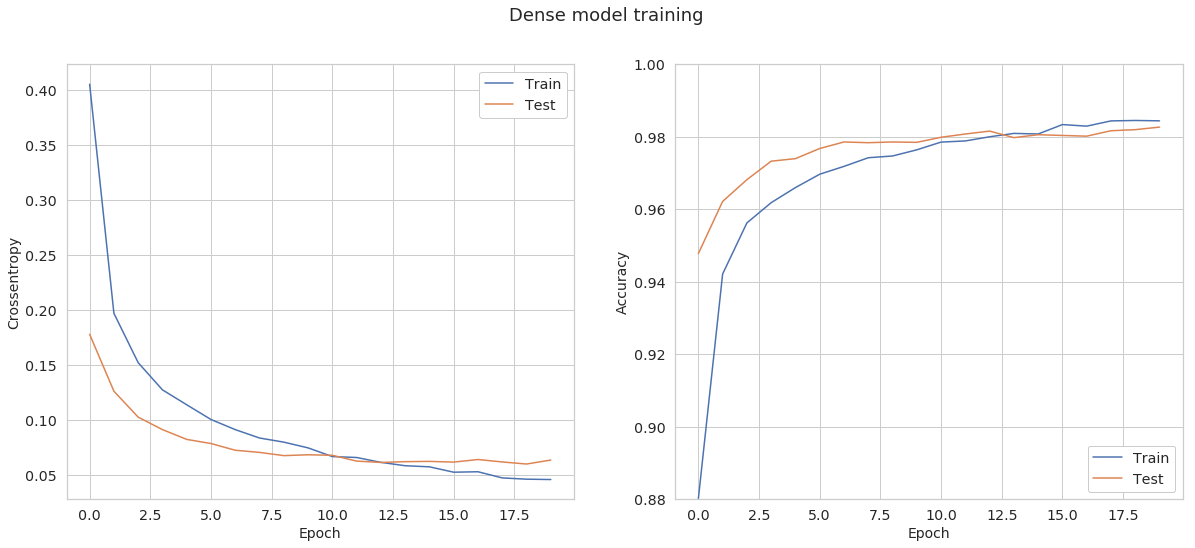

In [50]:
plt.figure(figsize=(20, 8))
plt.suptitle("Dense model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.ylim([0.88, 1.0]);

Table to store the results of the experiments

In [0]:
score_train = model_dense.evaluate(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, verbose=0)
score_test = model_dense.evaluate(X_test.reshape((len(X_test), img_cols * img_rows)), y_test, verbose=0)

In [0]:
results = pd.DataFrame(columns=["Architecture", "Epoch time", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])
results.loc[len(results)] = np.array(["784-128-128-128-10", "2secs", score_train[1], score_test[1], score_train[0], score_test[0]])
results.index = ["MLP"]

In [53]:
results

,Architecture,Epoch time,Accuracy Train,Accuracy Test,Loss Train,Loss Test
MLP,784-128-128-128-10,2secs,0.9962666666666666,0.9827,0.013983017520932482,0.06370132064592908


In [70]:
print(y_train[0:19])#0 4 1 2 3

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [78]:


#y_train_selected=np.append(y_train_selected,y_train[metrix:metrix+1],axis=0)
even=y_train[1:2]
odd=y_train[3:4]
for i in [ 5,2,13,17]:
  even=np.append(even,y_train[i:i+1],axis=0)
for i in [ 7,0,15,4]:
  odd=np.append(odd,y_train[i:i+1],axis=0)

  

          
if y_train[1:2] in even:
  print(even)
print(odd)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
#tuple & list operation
tup=(1,2,3,4,5)
lst=list(tup)
print(len(lst))

i=0
while i < len(lst):
    if (lst[i]%2)==0:
        lst[i]=0
    else:
        lst[i]=1
    i+=1
print(lst)

tup=tuple(lst)
print(tup)


5
[1, 0, 1, 0, 1]
(1, 0, 1, 0, 1)


##Homework by Pepper



### Task 3.1 : choose a better MLP architecture



Using all the training data, search for a good CNN architecture to model the MNIST problem. Above we explored 784-128-128-128-10.
 

It is up to you what the model will be. Here are some things you need to decide:
1. how many DENSE layers?
```python
'3 dense layers'
'1 hidden layers'
```
* how manu neurons per layer
```python
'256 per layer'
```
* report the accuracy on the test data set
```python
'784-256-10		accuracy_train:0.99995	accuracy_test:0.982'
```
**Please paste your response here using the following format:** 
* Best archtecture is:  
```python
'784-256-10		
```
* Test accuracy: 
```python
'accuracy_train:0.99995	accuracy_test:0.982'
```
* Training time per epoch in seconds is : 
```python
'1secs'
```



In [0]:

#written by Pepper before 5pm Tuesday

results = pd.DataFrame(columns=["Architecture", "Epoch time", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])


for dense_layer in [4,3,2,1]:
  for neuron in [256,128,64,12]:
    architecture = '784-'+str(neuron)  
    
    model_dense = Sequential()  
    model_dense.add(Dense(neuron, input_shape=(img_rows * img_cols,), activation="relu"))
    
    time = 1
    while time < dense_layer:#pair other nodes using while loop
      architecture+='-'+str(neuron)   
      model_dense.add(Dense(neuron, activation="relu"))
      time+=1
             
'''
#2nd version
#def list_all_architecture():
neurons=[256,128,64,12]
for dense_layer in range(1,4):#list all achitecture using 2 for loops
  for n in range(1,4):
    architecture = '784-'+str(neurons[n]) #architecture name     
    
    model_dense = Sequential()  
    model_dense.add(Dense(neurons[n], input_shape=(img_rows * img_cols,), activation="relu"))
    
    
    
    while n < dense_layer:#pair other nodes using while loop
      architecture+='-'+str(neurons[n+1])  #architecture name   
      
      model_dense.add(Dense(neurons[n+1], activation="relu"))
      time+=1
 '''  
      
      
    model_dense.add(Dense(nb_classes, activation="softmax"))
    architecture+="-10"
      
    #compile before training & testing  
    model_dense.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #training & testing (thought this was plotting and deleted, and got 0.01% of accuracy)
    hist = model_dense.fit(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, 
          validation_data = (X_test.reshape((len(X_test), img_cols * img_rows)), y_test), 
          epochs=20, batch_size=128)

    
    
    score_train = model_dense.evaluate(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, verbose=0)
    score_test = model_dense.evaluate(X_test.reshape((len(X_test), img_cols * img_rows)), y_test, verbose=0)


      
    results.loc[len(results)] = np.array([architecture, "1secs", score_train[1], score_test[1], score_train[0], score_test[0]])
    #results.index = ["MLP"]

results
      
#list_all_architecture()
'''

'\n#written by Pepper before 5pm Tuesday\n\nresults = pd.DataFrame(columns=["Architecture", "Epoch time", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])\n\n\nfor dense_layer in [4,3,2,1]:\n  for neuron in [256,128,64,12]:\n    architecture = \'784-\'+str(neuron)  \n    \n    model_dense = Sequential()  \n    model_dense.add(Dense(neuron, input_shape=(img_rows * img_cols,), activation="relu"))\n    \n    time = 1\n    while time < dense_layer:#pair other nodes using while loop\n      architecture+=\'-\'+str(neuron)   \n      model_dense.add(Dense(neuron, activation="relu"))\n      time+=1\n             \n\'\'\n#def list_all_architecture():\nneurons=[256,128,64,12]\nfor dense_layer in range(1,4):#list all achitecture using 2 for loops\n  for n in range(1,4):\n    architecture = \'784-\'+str(neurons[n]) #architecture name     \n    \n    model_dense = Sequential()  \n    model_dense.add(Dense(neurons[n], input_shape=(img_rows * img_cols,), activation="relu"))\n    \n    \n

###Task 3.2 : with 500 training examples

Use only 500 examples per class (recall we  have only 10 classes) and find the best architecture. (HINT you can do  stratified sampling OR just random selxtion of 5,000 examples)

**Please paste your response here:** 
* Best archtecture is:  
784-256-256-256-256-10	
* Test accuracy: 

 0.8731
* Training time per epoch in seconds is : 

 1secs

In [90]:


import numpy as np
import random

'''


#X_train & y_train are matrices
list_random=np.random.random(500)*59999
#list_random=np.random.randint(2,len(X_train)-1)
for matrix in list_random:
  X_train_selected=X_train[0:1]
  y_train_selected=y_train[0:1]
  matrix= int(round(matrix))
  #print(len(list_random))
  #print(matrix)
  #print(X_train[matrix:matrix+1])
  X_train_selected=np.append(X_train_selected,X_train[matrix:matrix+1],axis=0)
  y_train_selected=np.append(y_train_selected,y_train[matrix:matrix+1],axis=0)

print(len(X_train_selected))
'''

#randomly select

X_train_selected=X_train[0:1]
y_train_selected=y_train[0:1]
X_test_selected=X_test[0:1]
y_test_selected=y_test[0:1]
#list_random=np.random.random(5)*(len(X_train)-1)
i=0
while(i<500):

    metrix=np.random.randint(2,59999)
    X_train_selected=np.append(X_train_selected,X_train[metrix:metrix+1],axis=0)
    y_train_selected=np.append(y_train_selected,y_train[metrix:metrix+1],axis=0)
    i=i+1
i=0
while(i<100):
    i=i+1
    metrix2=np.random.randint(2,10000)
    X_test_selected=np.append(X_test_selected,X_test[metrix:metrix+1],axis=0)
    y_test_selected=np.append(y_test_selected,y_test[metrix:metrix+1],axis=0)
    
#print(len(X_train_selected))

#train
results = pd.DataFrame(columns=["Architecture", "Epoch time", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])


for dense_layer in [4,3,2,1]:
  for neuron in [256,128,64,12]:
    architecture = '784-'+str(neuron)  
    
    model_dense = Sequential()  
    model_dense.add(Dense(neuron, input_shape=(img_rows * img_cols,), activation="relu"))
    
    time = 1
    while time < dense_layer:#pair other nodes using while loop
      architecture+='-'+str(neuron)   
      model_dense.add(Dense(neuron, activation="relu"))
      time+=1
             

      
      
    model_dense.add(Dense(nb_classes, activation="softmax"))
    architecture+="-10"
      
    #compile before training & testing  
    model_dense.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #training & testing (thought this was plotting and deleted, and got 0.01% of accuracy)
    hist = model_dense.fit(X_train_selected.reshape((len(X_train_selected), img_cols * img_rows)), y_train_selected, 
          validation_data = (X_test_selected.reshape((len(X_test_selected), img_cols * img_rows)), y_test_selected), 
          epochs=20, batch_size=128)

    
    
    score_train = model_dense.evaluate(X_train_selected.reshape((len(X_train_selected), img_cols * img_rows)), y_train_selected, verbose=0)
    score_test = model_dense.evaluate(X_test_selected.reshape((len(X_test_selected), img_cols * img_rows)), y_test_selected, verbose=0)


      
    results.loc[len(results)] = np.array([architecture, "1secs", score_train[1], score_test[1], score_train[0], score_test[0]])
    #results.index = ["MLP"]

results
      

Train on 501 samples, validate on 1 samples
Epoch 1/20
501/501 [==============================] - 2s 5ms/step - loss: 2.2094 - acc: 0.2455 - val_loss: 2.0540 - val_acc: 1.0000
Epoch 2/20
501/501 [==============================] - 0s 139us/step - loss: 1.7456 - acc: 0.6188 - val_loss: 1.2299 - val_acc: 1.0000
Epoch 3/20
501/501 [==============================] - 0s 132us/step - loss: 1.0779 - acc: 0.7585 - val_loss: 0.3095 - val_acc: 1.0000
Epoch 4/20
501/501 [==============================] - 0s 131us/step - loss: 0.5843 - acc: 0.8683 - val_loss: 0.0283 - val_acc: 1.0000
Epoch 5/20
501/501 [==============================] - 0s 132us/step - loss: 0.3767 - acc: 0.8982 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 6/20
501/501 [==============================] - 0s 134us/step - loss: 0.2420 - acc: 0.9281 - val_loss: 9.1976e-04 - val_acc: 1.0000
Epoch 7/20
501/501 [==============================] - 0s 131us/step - loss: 0.1596 - acc: 0.9561 - val_loss: 1.3251e-04 - val_acc: 1.0000
Epoch 8/20
5

,Architecture,Epoch time,Accuracy Train,Accuracy Test,Loss Train,Loss Test
0,784-256-256-256-256-10,1secs,1.0,1.0,0.0015059779488765996,1.3113030945532955e-06
1,784-128-128-128-128-10,1secs,1.0,1.0,0.01075358279495539,0.00024673406733199954
2,784-64-64-64-64-10,1secs,0.9940119760479041,1.0,0.05011437911012334,2.8729851692332886e-05
3,784-12-12-12-12-10,1secs,0.3373253504911107,0.0,1.7292961498458466,1.5085625648498535
4,784-256-256-256-10,1secs,1.0,1.0,0.0033164129740262996,7.152582838898525e-06
5,784-128-128-128-10,1secs,1.0,1.0,0.01525082491234153,0.00024065289471764117
6,784-64-64-64-10,1secs,0.9900199600798403,1.0,0.08408790651314749,0.0006479335715994239
7,784-12-12-12-10,1secs,0.7125748511322006,1.0,1.1814940085192165,0.4885764718055725
8,784-256-256-10,1secs,1.0,1.0,0.0099775769074862,1.0728893357736524e-05
9,784-128-128-10,1secs,0.9960079840319361,1.0,0.04348168616181243,0.0005690286052413285





### Task 3.3 : Odd versus Even Classifier

Build a binary classifier that classifiers odd numbers versus even numbers. Again, try to find the best architecture.


**Please paste your response here:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 


Please send the following by EMAIL to James.Shanahan@gmail.com with the subject "Sichuan2019: MNIST Best MLP Architecture"

* Link to Coogle Colab notebook
* all the text + your response from this cell

In [0]:
import numpy as np

results = pd.DataFrame(columns=["Architecture", "Epoch time", "Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])


for dense_layer in [4,3,2,1]:
  for neuron in [256,128,64,12]:
    architecture = '784-'+str(neuron)  
    
    model_dense = Sequential()  
    model_dense.add(Dense(neuron, input_shape=(img_rows * img_cols,), activation="relu"))
    
    time = 1
    while time < dense_layer:#pair other nodes using while loop
      architecture+='-'+str(neuron)   
      model_dense.add(Dense(neuron, activation="relu"))
      time+=1
    
    
    #exchange results in y_train from 1-10 to 1/0
    #y_train manifying
    even=y_train[1:2] #creat even & odd training data
    odd=y_train[3:4]
    for i in [ 5,2,13,17]:
      even=np.append(even,y_train[i:i+1],axis=0)
    for i in [ 7,0,15,4]:
      odd=np.append(odd,y_train[i:i+1],axis=0)

    y_train_classify=y_train[1:1]
    i=0
    while i < len(y_train):
      if y_train[i:i+1] in even:
        y_train_classify=np.append(y_train_classify,y_train[1:2],axis=0)
      else:
        y_train_classify=np.append(y_train_classify,y_train[3:4],axis=0)
      i+=1
      
      
    #y_test manifying   
    i=0
    y_test_classify=y_test[1:1]
    while i < len(y_test):
    
      if y_test[i:i+1] in even:
        y_test_classify=np.append(y_test_classify,y_train[1:2],axis=0)
      else:
        y_test_classify=np.append(y_test_classify,y_train[3:4],axis=0)
      i+=1
      
      
    model_dense.add(Dense(nb_classes, activation="softmax"))
    architecture+="-2"
      
    #compile before training & testing  
    model_dense.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #training & testing (thought this was plotting and deleted, and got 0.01% of accuracy)
    hist = model_dense.fit(X_train.reshape((len(X_train), img_cols * img_rows)), y_train_classify, 
          validation_data = (X_test.reshape((len(X_test), img_cols * img_rows)), y_test_classify), 
          epochs=20, batch_size=128)

    
    
    score_train = model_dense.evaluate(X_train.reshape((len(X_train), img_cols * img_rows)), y_train_classify, verbose=0)
    score_test = model_dense.evaluate(X_test.reshape((len(X_test), img_cols * img_rows)), y_test_classify, verbose=0)


      
    results.loc[len(results)] = np.array([architecture, "1secs", score_train[1], score_test[1], score_train[0], score_test[0]])
    #results.index = ["MLP"]

results
      

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.0126 - acc: 0.9984 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/20
60000/60000 [==============================] - 7s 122us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/20
60000/60000 [==============================] - 7s 122us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/20
60000/60000 [==============================] - 7s 121us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/20
60000/60000 [==============================] - 7s 119us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/20
60000/60000 [==============================] - 7s 120us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/20
60000/60000 [==============================] - 7s 121us/step - loss

,Architecture,Epoch time,Accuracy Train,Accuracy Test,Loss Train,Loss Test
0,784-256-256-256-256-2,1secs,1.0,1.0,1.1920928955078125e-07,1.1920928955078125e-07
1,784-128-128-128-128-2,1secs,1.0,1.0,1.199682575437085e-07,1.1942386636292213e-07
2,784-64-64-64-64-2,1secs,1.0,1.0,1.2025038532404627e-07,1.2082457969881945e-07
3,784-12-12-12-12-2,1secs,1.0,1.0,1.4509509328490822e-07,1.517779495316063e-07
4,784-256-256-256-2,1secs,1.0,1.0,1.1928478880539236e-07,1.1928081516998645e-07
5,784-128-128-128-2,1secs,1.0,1.0,1.2095173860871e-07,1.206219245432294e-07
6,784-64-64-64-2,1secs,1.0,1.0,1.2006759756483612e-07,1.2333991935520318e-07
7,784-12-12-12-2,1secs,1.0,1.0,5.698952008970082e-07,7.028974341665162e-07
8,784-256-256-2,1secs,1.0,1.0,1.1962652273875088e-07,1.1975765355600743e-07
9,784-128-128-2,1secs,1.0,1.0,1.2181302442210533e-07,1.2374522316349611e-07


# Building CNN model

Now it's time to build the model step-by-step

In [0]:
model_cnn = Sequential()

Out model is going to be *Sequential* which means that every new added layer will be automatically connected to the previous one.

Firstly, let's define hyperparameters of the network:
* **filters** $-$ number of filters (or kernels) to use in every layer; in fact this is the same as having multiple channels in the image
* **pool_size** $-$ size of the pooling window
* **kernel_size** $-$ size of the convolutional filters

In [0]:
filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

Now let's add first layer of the network. It is 2D Convolutional layer. Only unexplained thing here is *padding*. This is the parameter that defines how should we pad the data after applying convolutions. $\text{padding} = \text{'valid'}$ means that we're not going to pad images and the dimension of it is going to shrink from layer to layer.

In [0]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid",
                            input_shape=input_shape))

Next step is to add nonlinearity to enable our network to learn complex dependencies. We're going to use ReLU activation function because it is less exposed to vanishing gradient problem and faster to train.

In [0]:
model_cnn.add(Activation('relu'))

Let's stack one more Convolution layer on top of that:

In [0]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid"))
model_cnn.add(Activation('relu'))

Now it's time to apply pooling. Note that the strategies of combining convolutional and pooling layers may be different. For further details see [here](http://cs231n.stanford.edu/)

In [0]:
model_cnn.add(MaxPooling2D(pool_size=pool_size))

At this point we consider that we've already distinguish some meaningful features from the pictures. So it's time to classify them. For that purpose the common approach is to append fully-connected part. 

But before that we need to pull all the obtained feature into one vector so that one object has 1D-vector of features. It is done by means of $\text{Flatten}$ layer.

In [0]:
model_cnn.add(Flatten())

Now let's add FC part with the [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) to avoid overfitting.

In [0]:
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(nb_classes, activation="softmax"))

The final layer here is usual $\text{Softmax}$ with the number of classe. So as the output of the network we observe the probability of each class.

Now let's compile our model.
* **optimizer** $-$ here we use accelerated gradient descent algorithm with special adaptive way of choosing learning rate; for more details see this great [overview](http://sebastianruder.com/optimizing-gradient-descent/) of gradient descent optimization algorithms.
* **loss** $-$ usual choice for multiclass classification is softmax output layer in combination with categotical crossentropy loss function which is
$$
\mathcal{L}(\text{true}, \text{pred}) = -\sum_{j=1}^{k}\text{true}_j \cdot \log \{\text{pred}_j\}
$$
* **metrics** $-$ additional metrics that we're going to trace while training; it doesn't influence training process at all

In [0]:
model_cnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Let's take a look at our final model now:

In [0]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4608)              0         
__________

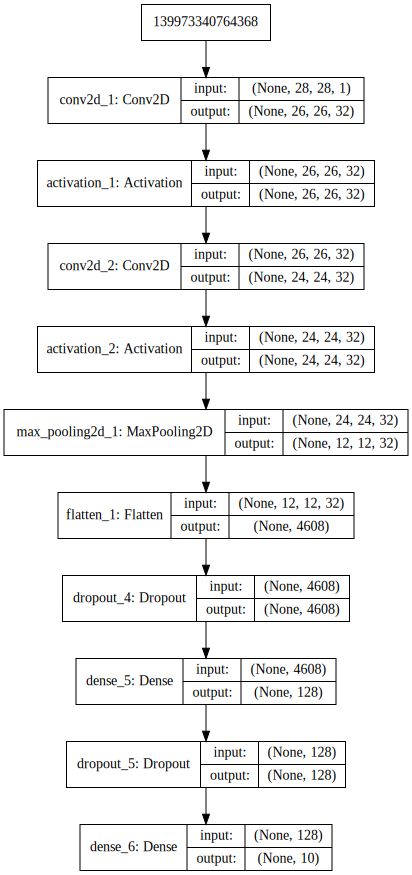

In [0]:
SVG(model_to_dot(model_cnn, show_shapes=True).create(prog='dot', format='svg'))

## Training

Training parameters are the following:
* nb_epoch $-$ number of epochs to train. here we choose 12; one may condiser using some stopping criterias
* **batch_size** $-$ parameter that controls how frequent do we update gradient; with $\text{batch_size}=1$ optimization is nothing but pure Stohastic Gradient Descent (update gradient after passing each one object); with $\text{batch_size}=\textit{number of objects}$ it will be usual Gradient Descent which updates gradient only after passing all objects. Choosing value between this two one can control speed and convergence of training process.

In [0]:
batch_size = 128
epochs = 5

Train!

In [0]:
hist = model_cnn.fit(X_train, y_train, 
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 117s 2ms/step - loss: 0.3019 - acc: 0.9076 - val_loss: 0.0622 - val_acc: 0.9803
Epoch 2/5
60000/60000 [==============================] - 117s 2ms/step - loss: 0.1086 - acc: 0.9679 - val_loss: 0.0464 - val_acc: 0.9851
Epoch 3/5
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0864 - acc: 0.9739 - val_loss: 0.0394 - val_acc: 0.9877
Epoch 4/5
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0717 - acc: 0.9784 - val_loss: 0.0350 - val_acc: 0.9882
Epoch 5/5
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0649 - acc: 0.9797 - val_loss: 0.0337 - val_acc: 0.9891


## Evaluation

Visualization of learning process:

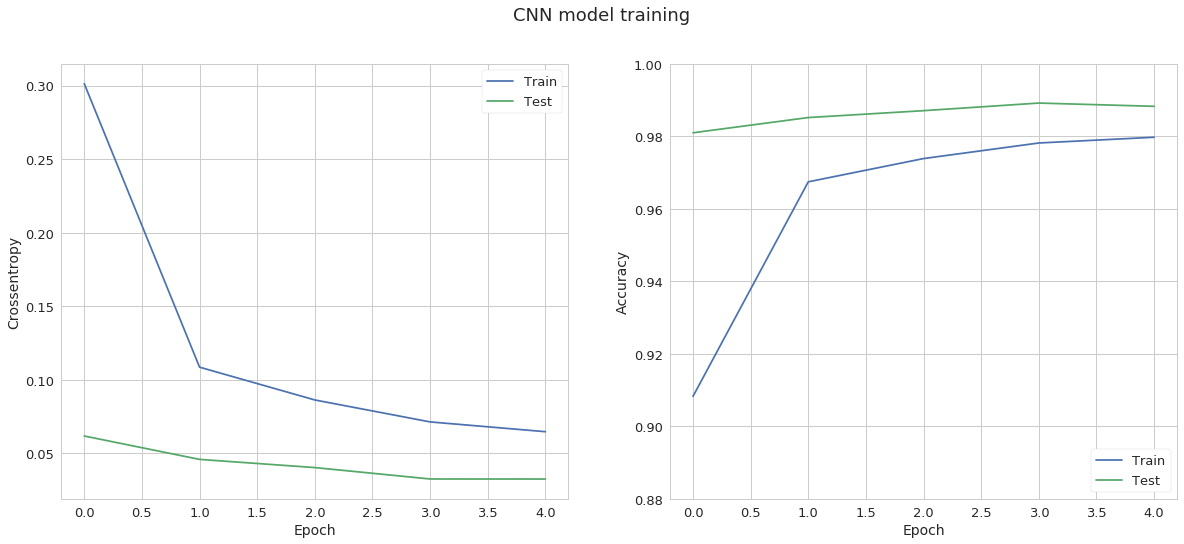

In [0]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.ylim([0.88, 1.0]);

Final evaluation of the model:

In [0]:
score_train = model_cnn.evaluate(X_train, y_train, verbose=0)
score_test = model_cnn.evaluate(X_test, y_test, verbose=0)

In [0]:
results.loc[len(results)] = np.array([score_train[1], score_test[1], score_train[0], score_test[0]])
results.index = ["MLP", "CNN"]

In [0]:
results

,Accuracy Train,Accuracy Test,Loss Train,Loss Test
MLP,0.9862,0.9746,0.045773,0.090305
CNN,0.9934,0.9883,0.021616,0.032652


# Task: choose a better architecture

Search for a good CNN architecture to model the MNIST problem.


**Test:train:validation:** Keep the test dataset as a held out dataset to report your final results. Use 20% of the training as your validation set and make all decisions regarding  architecture choices using the validation set (or subsets of the original training set).  

It is up to you what the model will be. Here are some things you need to decide:
* how many convolutional layers?
* what spatial size will your convolutions be?
* how many channels will your convolutions be?
* what nonlinearity will you use?
* will you use pooling? what type?
* how many fully-connected layers will you have?
* will you use dropout?
* what batch size?

Keras provides a special layer called `Flatten` to flatten the convolutional features into a vector before the fully-connected layers. You should look at the documentation for Keras's convolutional layers: http://keras.io/layers/convolutional/. In particular, you may want to look at `Convolution2D`, `MaxPooling2D`, `AveragePooling2D`, `Flatten`, and `Dropout`. For this problem, you make want to use the `'rmsprop'` optimizer - it is an algorithm that adapts the learning rate during learning for you automatically.


## load MNIST data

In [0]:
import numpy as np
import pandas as pd

import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
# load MNIST data
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
img_rows, img_cols = 28, 28
number_of_classes = 10
print(f"X before flatten train      shape: {X_train.shape}")
print(f"X before flatten validation shape: {X_valid.shape}")
print(f"X before flatten test       shape: {X_test.shape}")
#Here we're going to use dense baseline models so we need to represent our data as 1-dimensional vectors
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_test.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#Tensorflow prefers to work with float32 data type. 
#So the next step is to cast data. 
# Also let's have our data in [0; 1]interval; it's common choice for grayscale images.

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")

X before flatten train      shape: (48000, 28, 28)
X before flatten validation shape: (12000, 28, 28)
X before flatten test       shape: (10000, 28, 28)
X train      shape: (48000, 28, 28, 1), (48000,)
X validation shape: (12000, 28, 28, 1),  (12000,)
X test       shape: (10000, 28, 28, 1),  (10000,)


## Setup the MNIST data
Setup the MNIST data. Here we use  **digits 0 to 9**. 

Convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer of CNN

In [0]:
y_train = to_categorical(y_train, number_of_classes)
y_valid = to_categorical(y_valid, number_of_classes)
y_test  = to_categorical(y_test, number_of_classes)

In [0]:
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")

X train      shape: (48000, 28, 28, 1), (48000, 10)
X validation shape: (12000, 28, 28, 1),  (12000, 10)
X test       shape: (10000, 28, 28, 1),  (10000, 10)


In [0]:
    
num_classes = y_test.shape[1]
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),
                 activation='relu', padding="valid",
                 input_shape=input_shape))  #r, c, depth
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
__________

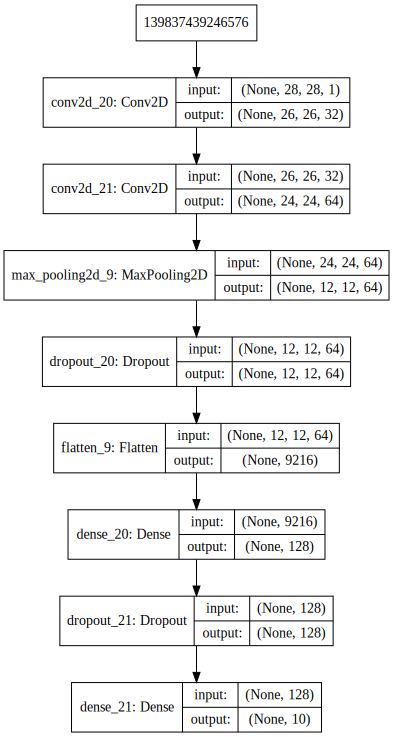

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, ).create(prog="dot", format="svg"))

### Early stopping callback:
* **monitor = "val_loss"** means that we're going to trace validation categorical crossentropy loss
* **patience = 3** shows how many epochs without improvement can we wait for until stop training

In [0]:
es = EarlyStopping(monitor="val_loss", patience=3)

### Model checkpoint callback

In [0]:
mc = ModelCheckpoint(filepath="./chkpt", 
                     monitor="val_loss", 
                     save_best_only=True)

Fitting

In [0]:
%%time
hist = model.fit(X_train, y_train, 
                 batch_size=256, 
                 epochs=5, 
                 verbose=1, 
                 callbacks=[es, mc], 
                 validation_data=(X_valid, y_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 79s 2ms/step - loss: 0.3381 - acc: 0.8963 - val_loss: 0.0806 - val_acc: 0.9780
Epoch 2/5
48000/48000 [==============================] - 77s 2ms/step - loss: 0.1066 - acc: 0.9685 - val_loss: 0.0540 - val_acc: 0.9843
Epoch 3/5
48000/48000 [==============================] - 85s 2ms/step - loss: 0.0799 - acc: 0.9752 - val_loss: 0.0453 - val_acc: 0.9871
Epoch 4/5
48000/48000 [==============================] - 78s 2ms/step - loss: 0.0631 - acc: 0.9809 - val_loss: 0.0403 - val_acc: 0.9883
Epoch 5/5
48000/48000 [==============================] - 79s 2ms/step - loss: 0.0523 - acc: 0.9837 - val_loss: 0.0419 - val_acc: 0.9885
CPU times: user 20min 33s, sys: 2min 26s, total: 23min
Wall time: 6min 39s


Training evolution

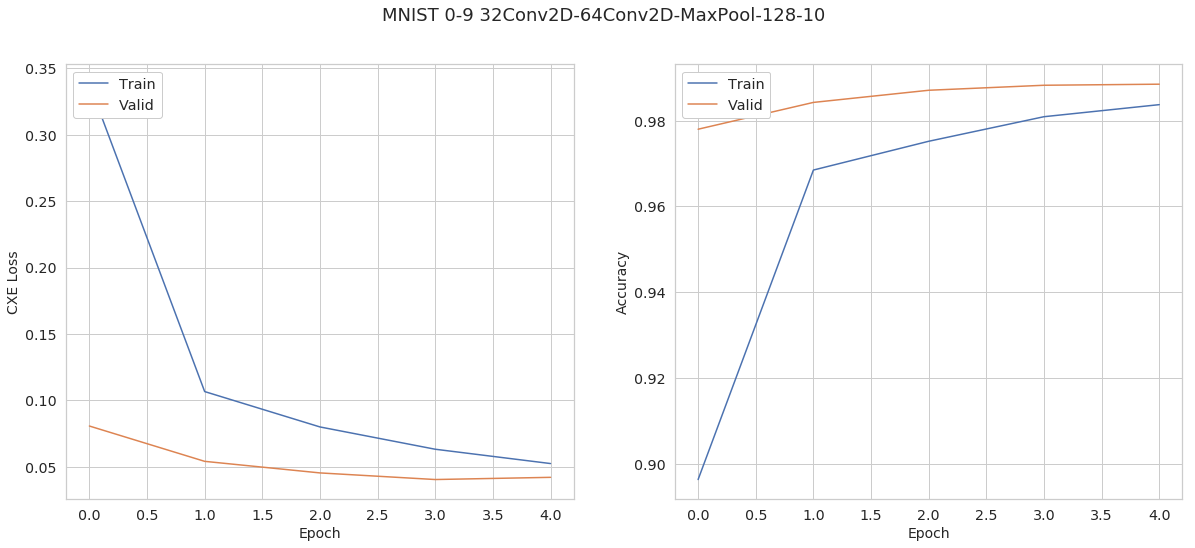

In [0]:
exp_name = "MNIST 0-9 32Conv2D-64Conv2D-MaxPool-128-10 "
plt.figure(figsize=(20, 8))
plt.suptitle(f"{exp_name}", fontsize=18)

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("CXE Loss", fontsize=14)
plt.subplot(122)

plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Valid")
plt.legend(loc="upper left")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Load the best model

In [0]:
model = load_model(filepath="chkpt")

Evaluate it

In [0]:
# Returns the loss value & metrics values for the model in test mode.
# CXE and accuracy
model.evaluate(X_test,  y_test, verbose=1)

10000/10000 [==============================] - 4s 438us/step


[0.03445024271312868, 0.9894]

In [0]:
# add the result of this experiment to the log book
expLog = pd.DataFrame(columns=["exp_name","Train CXE Loss", "Train Acc", "Validation CXE Loss", "Validation  Acc",
                    "Test CXE Loss", "Test  Accuracy"])
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(np.reshape([model.evaluate(X_train, y_train, verbose=0), 
                   model.evaluate(X_valid, y_valid, verbose=0),
                   model.evaluate(X_test,  y_test, verbose=1)], -1), 3))
expLog

10000/10000 [==============================] - 4s 434us/step


,exp_name,Train CXE Loss,Train Acc,Validation CXE Loss,Validation Acc,Test CXE Loss,Test Accuracy
0,MNIST 0-9 32Conv2D-64Conv2D-MaxPool-128-10,0.023,0.993,0.04,0.988,0.034,0.989


In [0]:
# If subtract pixel mean is enabled
#if subtract_pixel_mean:
X_train_mean = np.mean(X_train, axis=0)
#    x_train -= x_train_mean
#    x_test -= x_train_mean


In [0]:
X_train_mean.shape 
(48000, 28, 28, 1) --> (28, 28, 1)

(28, 28, 1)

In [0]:
X_train.shape

(48000, 28, 28, 1)